#### imports

In [18]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [2]:
# Load the California Housing dataset
california_housing = fetch_california_housing()
target_column='target'

# Create a DataFrame for better visualization (optional)
data = pd.DataFrame(data=california_housing.data, columns=california_housing.feature_names)
data[target_column] = california_housing.target

# Display the first few rows of the dataset
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


#### descriptives

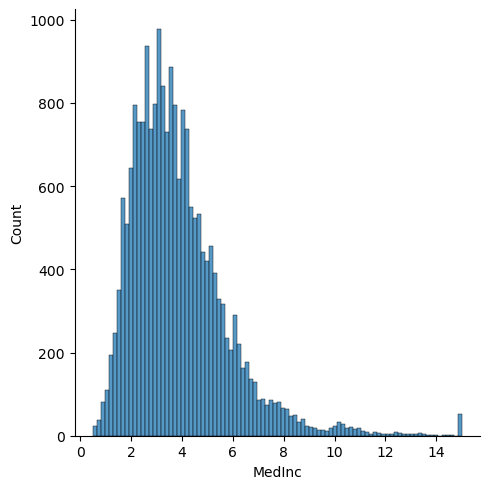

In [4]:
#distributions
sns.displot(data=data, x='MedInc')

In [5]:
#check nulls
data.isna().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

In [6]:
#describe
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


### preprocessing

In [8]:
X = data.drop(target_column, axis=1)
y = data[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train.shape, X_test.shape, X.shape

((16512, 8), (4128, 8), (20640, 8))

In [10]:
# Impute null values
num_imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(num_imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(num_imputer.transform(X_test), columns=X_test.columns)

In [11]:
# Scaling
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_imputed.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_test_imputed.columns)

In [12]:
# Feature Selection using RandomForestRegressor
feature_selector = SelectFromModel(RandomForestRegressor())
X_train_selected = feature_selector.fit_transform(X_train_scaled, y_train)
X_test_selected = feature_selector.transform(X_test_scaled)

#### modeling

In [14]:
# Hyperparameter grid for grid search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [4]
}

# Grid Search with RandomForestRegressor
rf_regressor = RandomForestRegressor()
grid_search = GridSearchCV(rf_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10], 'min_samples_leaf': [4],
                         'min_samples_split': [5], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error')

In [17]:
# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
print("Best MSE:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Best MSE: -0.5470315215742845


In [16]:
# Evaluate the model on the test set
X_test_selected = feature_selector.transform(X_test_scaled)
y_pred = grid_search.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

Mean Squared Error on Test Set: 0.5637452045791944
